# Módulo 6 - Aprendizaje profundo
## Clase 2: Autoencoders

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import gdown
#https://www.kaggle.com/datasets/rahmasleam/bird-speciees-dataset

url = 'https://drive.google.com/uc?export=download&id=1Ik5_xAR2g4e92tcZHo7MlJSBMfpo3t6m'
destination = "bird-speciees-dataset.zip"
gdown.download(url, destination, quiet=False)

# Descomprimir el dataset
!unzip bird-speciees-dataset.zip -d bird_species_dataset

Downloading...
From: https://drive.google.com/uc?export=download&id=1Ik5_xAR2g4e92tcZHo7MlJSBMfpo3t6m
To: /content/bird-speciees-dataset.zip
100%|██████████| 16.0M/16.0M [00:00<00:00, 103MB/s] 


Archive:  bird-speciees-dataset.zip
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/001.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/002.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/003.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/004.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/005.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/006.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/007.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/008.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/009.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/010.jpg  
  inflating: bird_species_dataset/Bird Speciees Dataset/AMERICAN GOLDFINCH/011.jpg  
  inflating: bird_species_dat

In [ ]:
!ls 'bird_species_dataset/Bird Speciees Dataset'

'AMERICAN GOLDFINCH'  'CARMINE BEE-EATER'  'EMPEROR PENGUIN'
'BARN OWL'	      'DOWNY WOODPECKER'    FLAMINGO


In [ ]:
# Cambiar el tamaño de las imágenes a 224x224
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Directorio de datos
data_dir = 'bird_species_dataset/Bird Speciees Dataset'

# Cargar el dataset completo
full_dataset = ImageFolder(data_dir, transform=train_transforms)

In [ ]:
#Dividir el dataset en entrenamiento y validación
train_size = int(0.8 * len(full_dataset))  # 80% para entrenamiento
val_size = len(full_dataset) - train_size  # 20% para validación

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Aplicar transformaciones específicas para validación
val_dataset.dataset.transform = val_transforms


In [ ]:
# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Obtener los nombres de las clases
class_names = full_dataset.classes
print("Clases:", class_names)


Clases: ['AMERICAN GOLDFINCH', 'BARN OWL', 'CARMINE BEE-EATER', 'DOWNY WOODPECKER', 'EMPEROR PENGUIN', 'FLAMINGO']


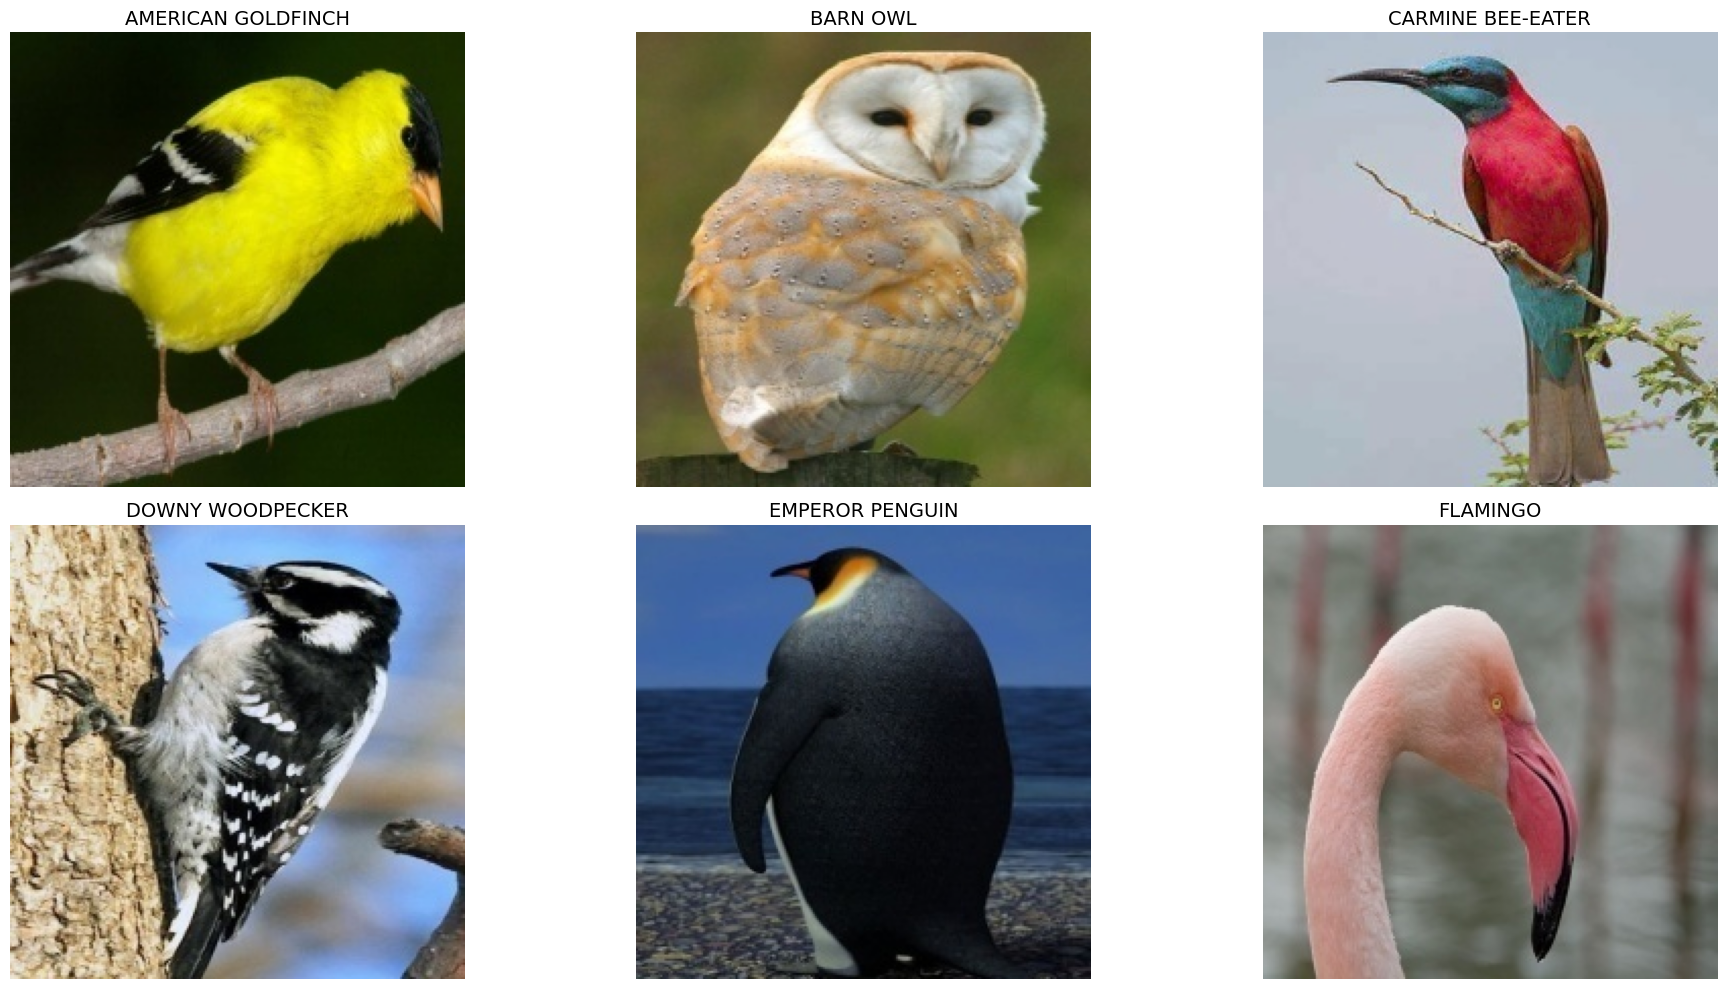

In [ ]:
# Visualizar imágenes aleatorias de entrenamiento por especie
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # Valores usados para normalizar
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormalizar
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=14)
    plt.axis('off')
    #plt.show()
# Crear un diccionario que mapea cada clase a los índices de sus imágenes en el conjunto de entrenamiento
class_indices = {i: [] for i in range(len(class_names))}

# Construir el mapeo de clases a índices
for idx in range(len(train_dataset)):
    _, label = train_dataset[idx]
    class_indices[label].append(idx)

# Seleccionar una imagen aleatoria por especie
images = []
labels = []

for label in range(len(class_names)):
    indices = class_indices[label]
    random_idx = random.choice(indices)
    img, _ = train_dataset[random_idx]
    images.append(img)
    labels.append(label)

# Mostrar las imágenes con sus etiquetas
num_images = len(images)
plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(2, 3, i+1)  # harcodeamos las 6 clases, 2 filas y 3 columnas
    imshow(images[i], title=class_names[labels[i]])

plt.tight_layout()
plt.show()


# Autoencoders

### ¿Qué es un Autoencoder?

Un **autoencoder** es un tipo de red neuronal que tiene como objetivo aprender una **representación comprimida** (codificación) de los datos de entrada, para luego reconstruir los mismos datos a partir de esa representación comprimida. En términos simples, un autoencoder aprende a comprimir los datos y a descomprimirlos para obtener una versión lo más cercana posible a la original.

### Componentes

Un autoencoder se divide en dos partes principales:

1. **Codificador (Encoder)**:
   - La función del codificador es comprimir los datos de entrada a una representación de menor dimensionalidad, conocida como el **espacio latente**.
   - A medida que la información pasa por el codificador, se reduce el número de características que describen los datos, lo que obliga al modelo a aprender las características más importantes y representativas.

2. **Decodificador (Decoder)**:
   - El decodificador toma la representación comprimida del espacio latente y trata de reconstruir los datos originales.
   - El objetivo es que la salida reconstruida sea lo más similar posible a la entrada original.

### Funcionamiento Básico de un Autoencoder

Un autoencoder recibe como entrada un conjunto de datos, por ejemplo, una imagen. El **codificador** transforma esa imagen en una representación comprimida (por ejemplo, una versión muy simplificada de la imagen con menos dimensiones). Luego, el **decodificador** toma esa representación comprimida y trata de reconstruir la imagen original.


Entrada → Codificador → Codificación → Decodificador → Salida Reconstruida


El objetivo del entrenamiento es minimizar la diferencia entre la **entrada original** y la **salida reconstruida**. Esta diferencia se mide con una función de pérdida, como el **Error Cuadrático Medio (MSE)**.

### Aplicaciones de Autoencoders

1. **Reducción de Dimensionalidad**:
   - Los autoencoders pueden ser utilizados para reducir la dimensionalidad de los datos, manteniendo solo la información esencial. Esto es similar a técnicas como el PCA (Análisis de Componentes Principales), pero de manera no lineal.

2. **Detección de anomalías**:
   - Dado que un autoencoder aprende a reconstruir datos "normales", cuando se le presenta un dato "anómalo" (que no sigue el mismo patrón que los datos de entrenamiento), el error de reconstrucción será más alto. Esto hace que los autoencoders sean útiles para detectar anomalías en datos.

3. **Eliminación de ruido (Denoising)**:
   - Los **Denoising Autoencoders** se entrenan para eliminar el ruido de los datos. En este caso, el autoencoder recibe datos con ruido como entrada y se le entrena para reconstruir una versión "limpia" de los mismos.

4. **Generación de datos**:
   - Los **autoencoders variacionales (VAE)** son una variante de los autoencoders que generan nuevas muestras de datos a partir de la codificación latente, siendo útiles para tareas como la generación de imágenes sintéticas.

### Tipos de Autoencoders

1. **Autoencoder clásico**:
   - La versión básica de un autoencoder que sigue la arquitectura de codificador-decodificador para comprimir y reconstruir datos.

2. **Variational Autoencoder (VAE)**:
   - En lugar de aprender una codificación única, un VAE aprende una distribución probabilística en el espacio latente, lo que permite generar datos nuevos de manera más variada y controlada.

3. **Denoising Autoencoder**:
   - Este tipo de autoencoder es entrenado para eliminar el ruido de los datos. Se le proporcionan datos ruidosos como entrada y se le entrena para reconstruir una versión sin ruido.

4. **Sparse Autoencoder**:
   - Utiliza una regularización para forzar que solo una pequeña cantidad de neuronas se activen al mismo tiempo, lo que ayuda a aprender representaciones más eficientes y útiles.

### Beneficios

- **No supervisados**: No requieren etiquetas para el entrenamiento, ya que el objetivo es reconstruir la entrada original.
- **Reducción de dimensionalidad**: Permiten reducir los datos a un espacio más pequeño sin perder información relevante.
- **Aprendizaje de características**: Ayudan a aprender representaciones más compactas y significativas de los datos.

### Desafíos

- **Reconstrucción precisa**: Si el autoencoder no se entrena adecuadamente, la reconstrucción puede no ser precisa.
- **Espacio Latente**: Elegir el tamaño adecuado para la codificación latente es crucial para lograr un buen equilibrio entre compresión y reconstrucción de los datos.


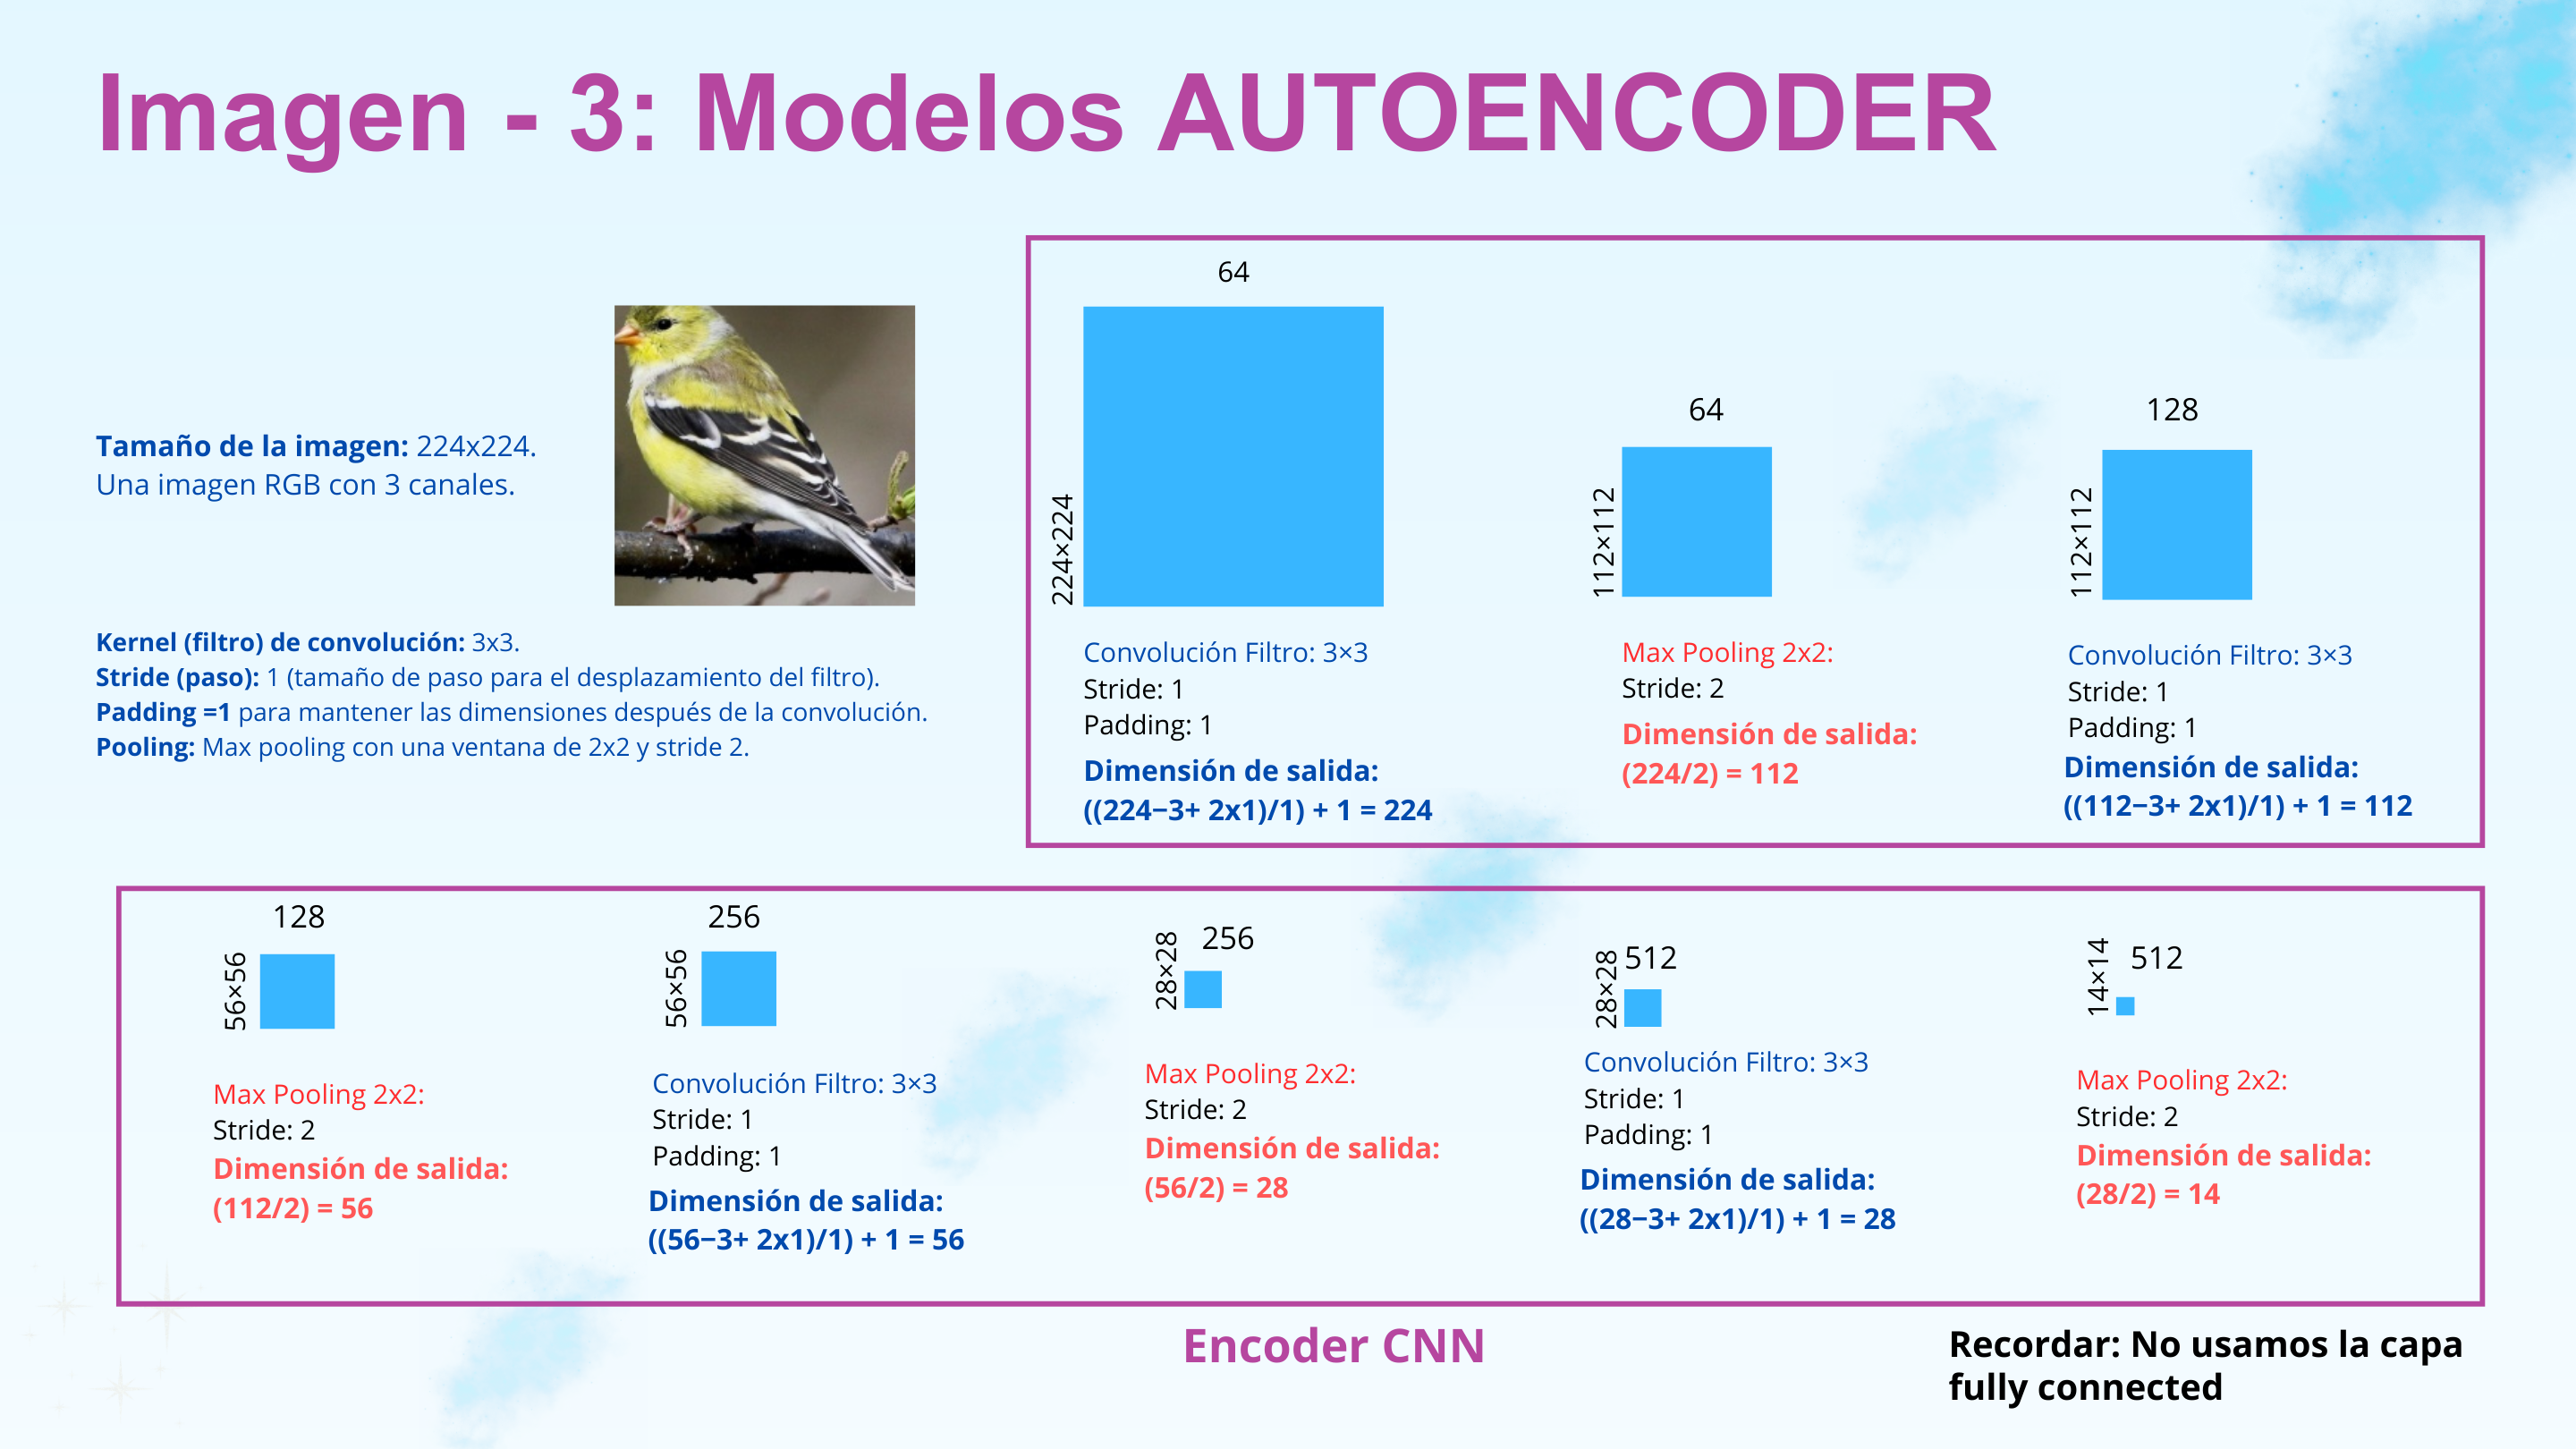

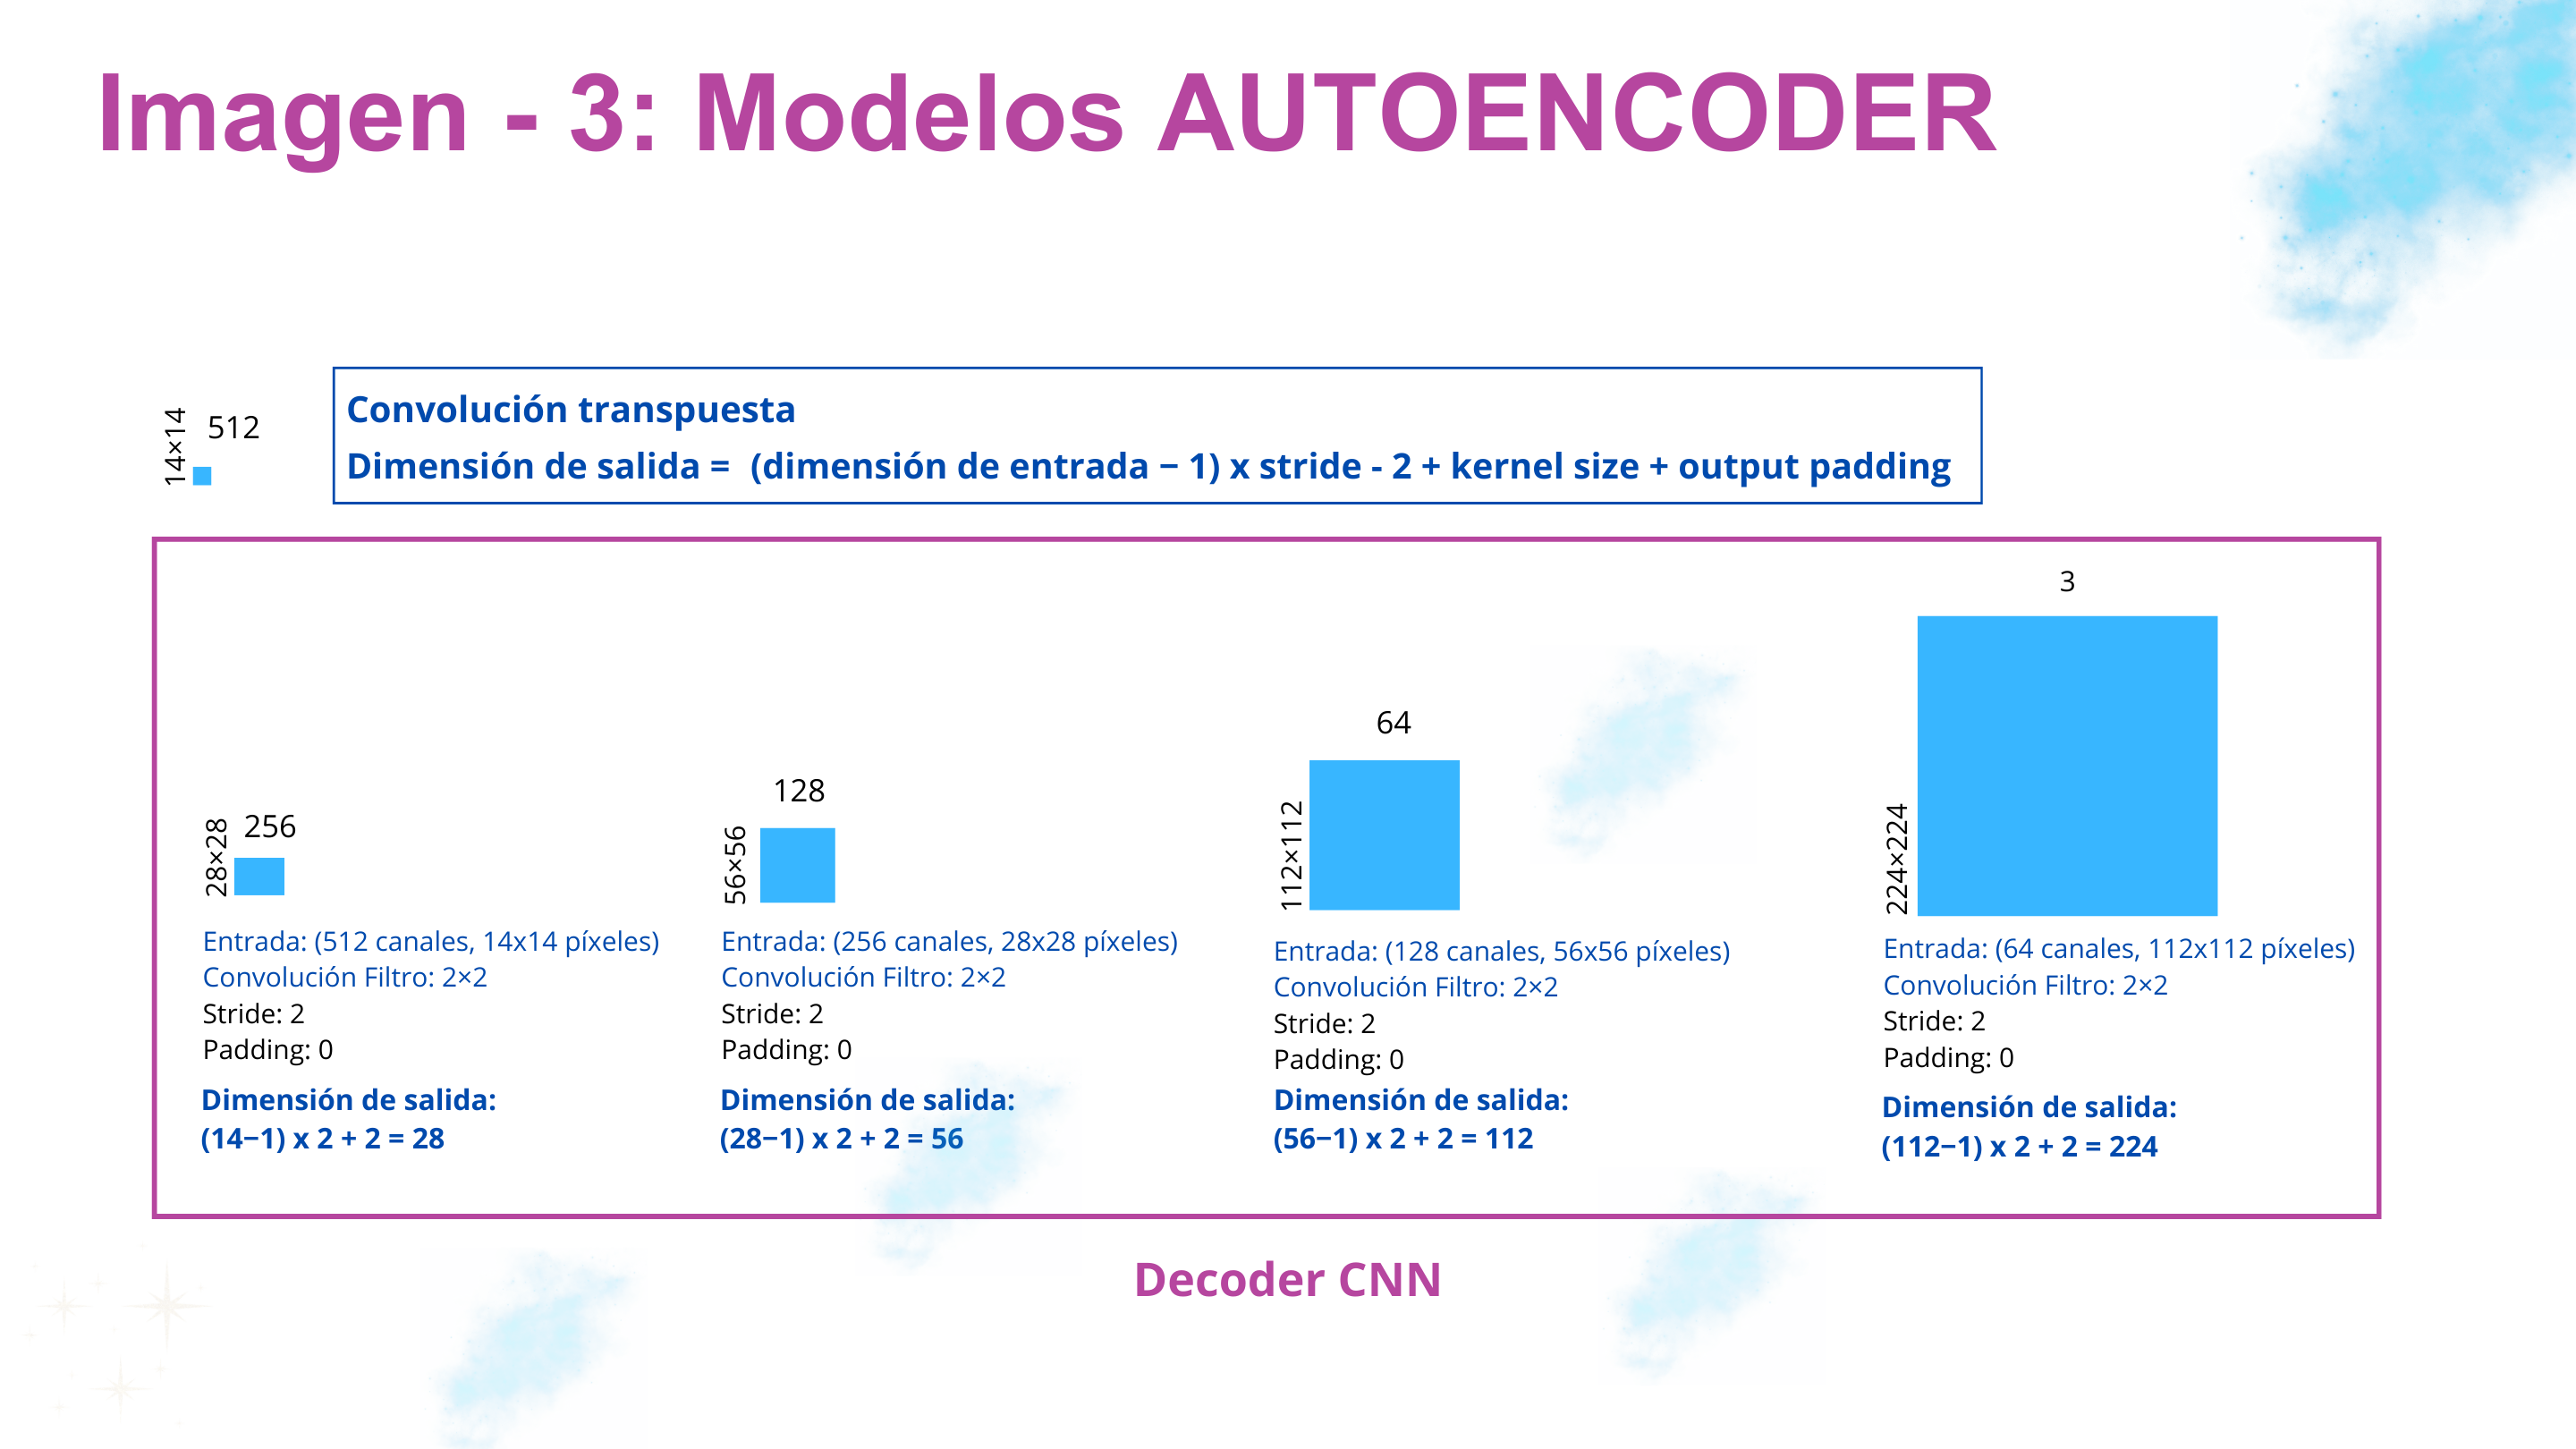

# Les dejamos 2 modelos

ToDo:

Corran el Modelo 1 - Entren - verifiquen salida

Corran el Modelo 2 - Entren - comparen salida con el anterior modelo 1

Modifiquen hiperparametros

In [ ]:
# Definir el Autoencoder
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()

        # Codificador (Encoder)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (224x224) -> (224x224)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (224x224) -> (112x112)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (112x112) -> (112x112)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (112x112) -> (56x56)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (56x56) -> (56x56)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (56x56) -> (28x28)

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # (28x28) -> (28x28)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (28x28) -> (14x14)
        )

        # Decodificador (Decoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # (14x14) -> (28x28)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # (28x28) -> (56x56)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # (56x56) -> (112x112)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),  # (112x112) -> (224x224)
            nn.Sigmoid()  # Asegura que los valores de salida estén entre 0 y 1 (para imágenes normalizadas)
        )

    def forward(self, x):
        # Paso por el codificador
        x = self.encoder(x)
        # Paso por el decodificador
        x = self.decoder(x)
        return x

# Crear una instancia del modelo Autoencoder
model = AutoencoderCNN()

# Generar un tensor de entrada aleatorio para verificar el funcionamiento del modelo
input_tensor = torch.rand((1, 3, 224, 224))  # Lote de 1 imagen RGB de tamaño 224x224

# Paso hacia adelante del tensor a través del modelo
output_tensor = model(input_tensor)

# Mostrar las dimensiones de entrada y salida
input_tensor.shape, output_tensor.shape

print("Modelo 1 listo!!!")

Modelo 1 listo!!!


In [ ]:
class AutoencoderCNN_ReducedLatent(nn.Module):
    def __init__(self):
        super(AutoencoderCNN_ReducedLatent, self).__init__()

        # Codificador con menos canales en la última capa
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  # Última capa reducida a 128 canales
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decodificador ajustado a la nueva dimensión de salida
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Crear una instancia del modelo con espacio de características reducido y probar
model2 = AutoencoderCNN_ReducedLatent()

# Generar un tensor de entrada aleatorio para verificar el funcionamiento del modelo
input_tensor = torch.rand((1, 3, 224, 224))  # Lote de 1 imagen RGB de tamaño 224x224

# Paso hacia adelante del tensor a través del modelo
output_tensor = model2(input_tensor)

# Mostrar las dimensiones de entrada y salida
input_tensor.shape, output_tensor.shape

print("Modelo 2 listo!!!")

Modelo 2 listo!!!


Entrenamiento

In [ ]:
import torch

def train_autoencoder(model, train_loader, device, criterion, optimizer, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Modo de entrenamiento
        model.train()
        running_loss = 0.0

        for inputs, _ in train_loader:  # No se necesitan etiquetas en un autoencoder
            inputs = inputs.to(device)

            # Inicializar gradientes
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Comparar salida con entrada original

            # Backward
            loss.backward()
            optimizer.step()

            # Estadísticas
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        print(f'Pérdida de entrenamiento: {epoch_loss:.4f}')

    return train_losses


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar la curva de pérdida
def graficar_perdida(train_losses, num_epochs):
    plt.plot(range(num_epochs), train_losses, label='Pérdida de entrenamiento')
    plt.legend(loc='upper right')
    plt.title('Pérdida de entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.show()

# Función auxiliar para mostrar una imagen
def imshow(img, title=None):
    img = img.detach().cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=14)
    plt.axis('on')

# Función para visualizar reconstrucciones de imágenes
def visualizar_reconstrucciones(model, val_loader, device, num_imagenes=6):
    model.eval()
    inputs, _ = next(iter(val_loader))
    inputs = inputs.to(device)

    # Generar las reconstrucciones
    with torch.no_grad():
        outputs = model(inputs)

    # Mostrar imágenes originales y reconstruidas
    plt.figure(figsize=(15, 5))
    for i in range(num_imagenes):
        # Imagen original
        plt.subplot(2, num_imagenes, i + 1)
        imshow(inputs[i].cpu())
        if i == 0:
            plt.ylabel('Originales', fontsize=14)

        # Imagen reconstruida
        plt.subplot(2, num_imagenes, i + 1 + num_imagenes)
        imshow(outputs[i].cpu())
        if i == 0:
            plt.ylabel('Reconstruidas', fontsize=14)
    plt.show()


Usando el dispositivo: cuda:0
Epoch 1/50
----------
Pérdida de entrenamiento: 0.8977
Epoch 2/50
----------
Pérdida de entrenamiento: 0.7773
Epoch 3/50
----------
Pérdida de entrenamiento: 0.7485
Epoch 4/50
----------
Pérdida de entrenamiento: 0.7377
Epoch 5/50
----------
Pérdida de entrenamiento: 0.7307
Epoch 6/50
----------
Pérdida de entrenamiento: 0.7276
Epoch 7/50
----------
Pérdida de entrenamiento: 0.7226
Epoch 8/50
----------
Pérdida de entrenamiento: 0.7180
Epoch 9/50
----------
Pérdida de entrenamiento: 0.7104
Epoch 10/50
----------
Pérdida de entrenamiento: 0.6987
Epoch 11/50
----------
Pérdida de entrenamiento: 0.6845
Epoch 12/50
----------
Pérdida de entrenamiento: 0.6814
Epoch 13/50
----------
Pérdida de entrenamiento: 0.6799
Epoch 14/50
----------
Pérdida de entrenamiento: 0.6748
Epoch 15/50
----------
Pérdida de entrenamiento: 0.6725
Epoch 16/50
----------
Pérdida de entrenamiento: 0.6725
Epoch 17/50
----------
Pérdida de entrenamiento: 0.6711
Epoch 18/50
----------
Pérd

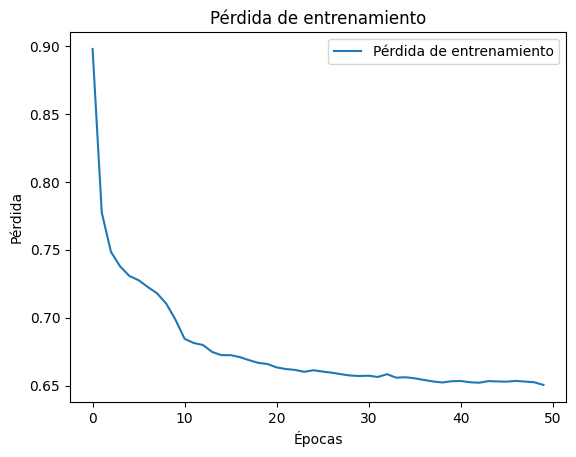

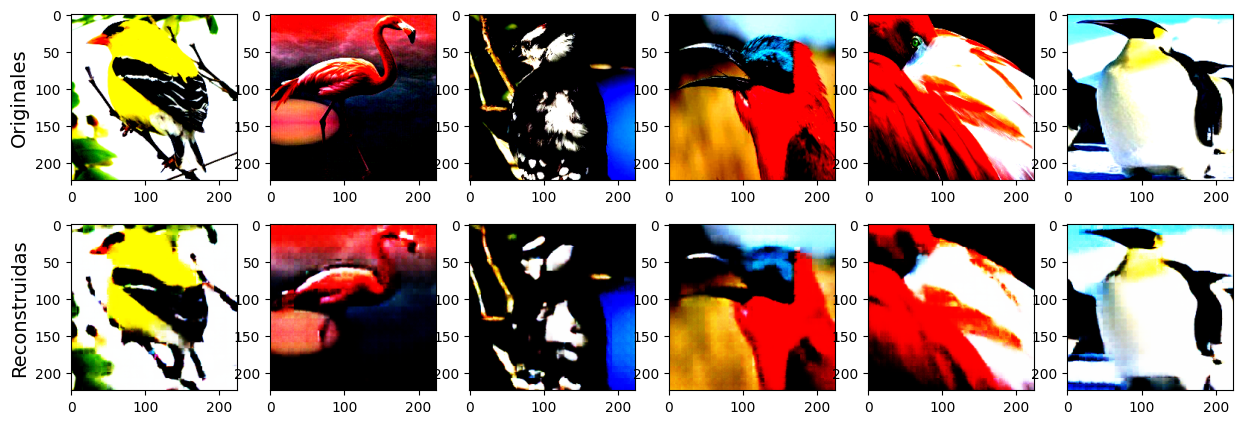

In [ ]:
# Modelo 1:

#Definir el dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Usando el dispositivo:", device)
model.to(device)

# Definir la función de pérdida y el optimizador (MSE para autoencoders)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de pérdida y el optimizador
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Entrenar el modelo
train_losses = train_autoencoder(model=model, train_loader=train_loader, device=device,
                                 criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)


# Graficar la pérdida de entrenamiento
graficar_perdida(train_losses=train_losses, num_epochs=num_epochs)

# Visualizar las imágenes originales y reconstruidas
visualizar_reconstrucciones(model=model, val_loader=val_loader, device=device)


Usando el dispositivo: cuda:0
Epoch 1/50
----------
Pérdida de entrenamiento: 0.9113
Epoch 2/50
----------
Pérdida de entrenamiento: 0.7820
Epoch 3/50
----------
Pérdida de entrenamiento: 0.7559
Epoch 4/50
----------
Pérdida de entrenamiento: 0.7392
Epoch 5/50
----------
Pérdida de entrenamiento: 0.7325
Epoch 6/50
----------
Pérdida de entrenamiento: 0.7298
Epoch 7/50
----------
Pérdida de entrenamiento: 0.7244
Epoch 8/50
----------
Pérdida de entrenamiento: 0.7219
Epoch 9/50
----------
Pérdida de entrenamiento: 0.7187
Epoch 10/50
----------
Pérdida de entrenamiento: 0.7144
Epoch 11/50
----------
Pérdida de entrenamiento: 0.7027
Epoch 12/50
----------
Pérdida de entrenamiento: 0.6863
Epoch 13/50
----------
Pérdida de entrenamiento: 0.6793
Epoch 14/50
----------
Pérdida de entrenamiento: 0.6755
Epoch 15/50
----------
Pérdida de entrenamiento: 0.6732
Epoch 16/50
----------
Pérdida de entrenamiento: 0.6705
Epoch 17/50
----------
Pérdida de entrenamiento: 0.6691
Epoch 18/50
----------
Pérd

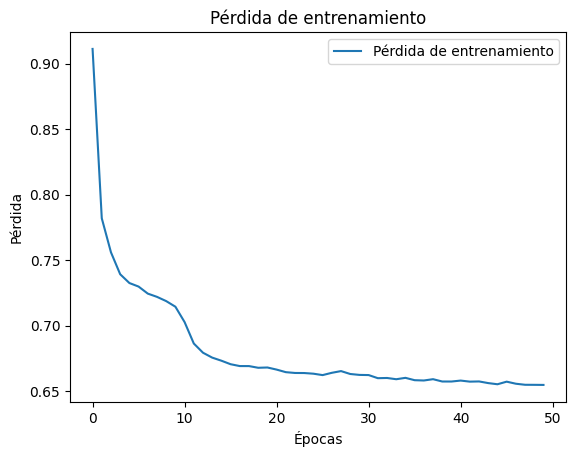

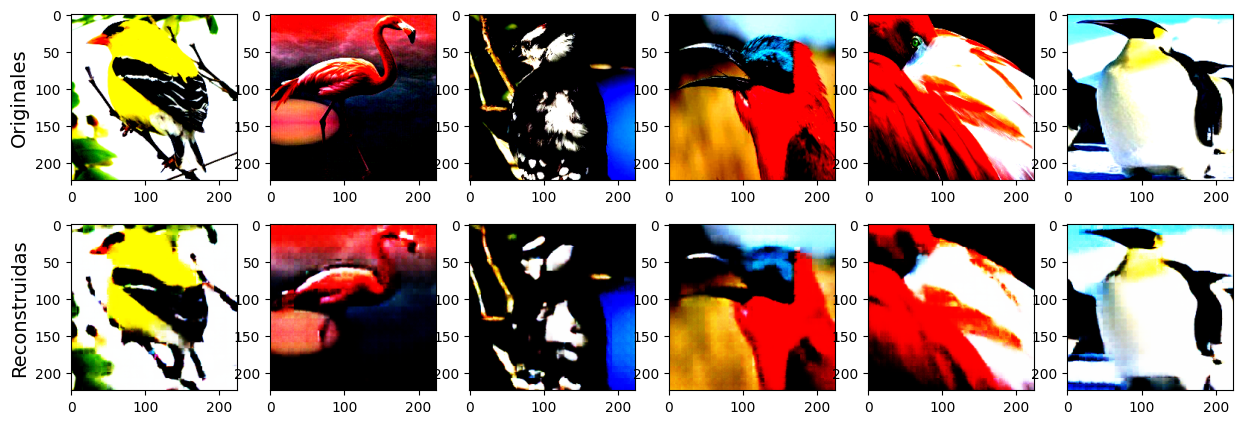

In [ ]:
# Modelo 2:

#Definir el dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Usando el dispositivo:", device)
model2.to(device)

# Definir la función de pérdida y el optimizador (MSE para autoencoders)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 50

# Definir la función de pérdida y el optimizador
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

# Entrenar el modelo
train_losses = train_autoencoder(model=model2, train_loader=train_loader, device=device,
                                 criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)


# Graficar la pérdida de entrenamiento
graficar_perdida(train_losses=train_losses, num_epochs=num_epochs)

# Visualizar las imágenes originales y reconstruidas
visualizar_reconstrucciones(model=model, val_loader=val_loader, device=device)

# Probamos el modelo
La idea: Si el modelo aprendio bien a recontruir, le podria pasar algo borroso cortado, distorsionado y el modelo deberia poder recontruirlo correctamente...

##**Prueba 2:** Imágen distorsionada

In [ ]:
import torch
import numpy as np
import random
import torchvision.transforms.functional as TF

# Función para distorsionar la imagen
def distort_image(img, noise_factor=3, rotation_degrees=15, contrast_factor=7, brightness_factor=7):

    # Convertir el tensor en un numpy array
    img = img.cpu().numpy().transpose((1, 2, 0))

    # 1. Agregar ruido gaussiano
    noisy_img = img + noise_factor * np.random.randn(*img.shape)
    noisy_img = np.clip(noisy_img, 0, 1)  # Asegurar que los valores estén entre 0 y 1

    # 2. Rotar la imagen aleatoriamente entre -rotation_degrees y +rotation_degrees
    angle = random.uniform(-rotation_degrees, rotation_degrees)
    noisy_img = TF.rotate(torch.tensor(noisy_img).permute(2, 0, 1), angle).numpy().transpose((1, 2, 0))

    # 3. Ajustar el contraste de la imagen
    noisy_img = TF.adjust_contrast(torch.tensor(noisy_img).permute(2, 0, 1), contrast_factor).numpy().transpose((1, 2, 0))

    # 4. Ajustar el brillo de la imagen
    noisy_img = TF.adjust_brightness(torch.tensor(noisy_img).permute(2, 0, 1), brightness_factor).numpy().transpose((1, 2, 0))


    # Convertir de vuelta a tensor
    distorted_img = torch.tensor(noisy_img).permute(2, 0, 1)

    return distorted_img


In [ ]:
# Visualizar las imágenes reconstruidas
def imshow(img, title=None):
    # Usar detach() para evitar el error al convertir a numpy
    img = img.detach().cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=14)
    plt.axis('on')

model.eval()
inputs, _ = next(iter(val_loader))
inputs = inputs.to(device)

# Aplicar distorsión a las imágenes de entrada
distorted_inputs = torch.stack([distort_image(img) for img in inputs]).to(device).float()

# Obtener las imágenes reconstruidas por el autoencoder
outputs = model(distorted_inputs)

# Mostrar imágenes originales, distorsionadas y reconstruidas
n = 6  # Número de imágenes para mostrar
plt.figure(figsize=(20, 10))
for i in range(n):
    # Originales
    plt.subplot(3, n, i + 1)
    imshow(inputs[i].cpu())
    if i == 0:
        plt.ylabel('Originales', fontsize=14)

    # Distorsionadas
    plt.subplot(3, n, i + 1 + n)
    imshow(distorted_inputs[i].cpu())
    if i == 0:
        plt.ylabel('Distorsionadas', fontsize=14)

    # Reconstruidas
    plt.subplot(3, n, i + 1 + 2 * n)
    imshow(outputs[i].cpu())
    if i == 0:
        plt.ylabel('Reconstruidas', fontsize=14)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Preguntas:

1. **¿Cuál es el objetivo de un autoencoder?**
2. **¿Cómo trabajan juntos el codificador y el decodificador?**
3. **¿Por qué comparamos la imagen reconstruida con la original?**
4. **¿Para qué se pueden usar los autoencoders?**
5. **¿Cómo influye el tamaño del espacio latente en el rendimiento?**
6. **¿Cómo reconstruye el autoencoder imágenes distorsionadas?**
7. **¿Qué ventaja tiene un autoencoder frente a PCA?**


## TODO: Experimentación para Autoencoders

### 1. Cambio en el Método de Upscaling
- Reemplaza las capas `ConvTranspose2d` en el decodificador por `nn.Upsample` con `mode='bilinear'` o `mode='nearest'`.
- Observa si hay cambios en la pérdida de entrenamiento y en la calidad visual de las imágenes reconstruidas.

### 2. Agregar Conexiones Skip
- Agrega conexiones directas entre capas del codificador y capas correspondientes del decodificador (por ejemplo, entre la primera capa del codificador y la última capa del decodificador).
- Al combinar las salidas del codificador y decodificador, puedes utilizar `torch.cat()` para concatenar los tensores en el eje de los canales.
- Entrena el autoencoder con estas modificaciones y observa si hay mejoras en la precisión de reconstrucción.


Al finalizar cada experimento, grafica las pérdidas y visualiza las imágenes reconstruidas para comparar el impacto de los cambios respecto a la arquitectura original.
